In [4]:
#! ls ./data_sets/* -lh
#https://github.com/chriswi93/Neural-Networks-and-Logistic-Regression-Backpropagation-in-depth

In [53]:
#more visualizations
#more datasets
from scipy.sparse import csr_matrix, find

import warnings
import pandas 
pandas.set_option('mode.use_inf_as_na', True)

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os

os.environ["PYTHONWARNINGS"] = "ignore"
# import pertpy as pt
import scanpy as sc

import pertpy as pt
# adata = pt.dt.kang_2018()
from torch import tensor
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from collections import defaultdict
rowGeneExpression2 = defaultdict(dict)
import math

one ='DatlingerBock2021.h5ad'
#one = 'AissaBenevolenskaya2021.h5ad'
#one = 'AissaBenevolenskaya2021.h5ad'
folders = '/home/awahab/llm-testing/data_sets/'
#one = 'AdamsonWeissman2016_GSM2406675_10X001.h5ad' #sigmoid returns nan in 0th frame
#one ='DatlingerBock2021.h5ad'


adata = sc.read_h5ad(folders + one)
#2. Non-negative matrix factorization (NMF)
#3. Linear discriminant analysis (LDA)
#adata.obs

sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata)
sc.pp.highly_variable_genes(adata, 
                                layer=None, 
                                n_top_genes=200, 
                                min_disp=0.5, 
                                max_disp=1, 
                                min_mean=0.0125, 
                                max_mean=3, 
                                span=0.3, 
                                n_bins=20, 
                                flavor='seurat_v3', 
                                subset=False, 
                                inplace=True, 
                                batch_key=None, 
                                check_values=True)

sc.pp.pca(adata)
#M = adata.X[:5000, ]
found = find(adata.X)
torch.manual_seed(440)

#adata.obs.drop(labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise')
#adata.obs = adata.iloc[:5000]
#adata.obs= adata.obs[adata.obs.iloc[:5000]]
#adata.obs.iloc[:5000]
#adata.var_names
var_df = adata.var
df = adata.obs#.iloc[:5000]
df = df.drop(columns=['nperts'])
df['percent_mito'] = 1

In [249]:
adata.var[adata.var['highly_variable'] == True]

,ensembl_id,ncounts,ncells,highly_variable,highly_variable_rank,means,variances,variances_norm
gene_symbol,,,,,,,,
ADRB1,ENSG00000043591,69.0,12,True,40.0,0.000467,0.000906,1.961213
EPN3,ENSG00000049283,31.0,4,True,14.0,0.000173,0.000400,2.070653
PRSS8,ENSG00000052344,20.0,4,True,24.0,0.000165,0.000308,2.020662
PICK1,ENSG00000100151,65.0,12,True,44.0,0.000483,0.000935,1.952672
SLC32A1,ENSG00000101438,54.0,11,True,64.0,0.000432,0.000811,1.906554
...,...,...,...,...,...,...,...,...
ENSG00000277767,ENSG00000277767,34.0,7,True,35.0,0.000255,0.000479,1.981933
ENSG00000278740,ENSG00000278740,22.0,3,True,4.0,0.000150,0.000324,2.223860
ENSG00000278765,ENSG00000278765,76.0,16,True,66.0,0.000548,0.001042,1.901123


In [250]:
adata.var[adata.var['highly_variable'] == False]

,ensembl_id,ncounts,ncells,highly_variable,highly_variable_rank,means,variances,variances_norm
gene_symbol,,,,,,,,
TSPAN6,ENSG00000000003,15.0,15,False,NaN,0.000265,0.000184,0.728603
TNMD,ENSG00000000005,8.0,8,False,NaN,0.000141,0.000098,0.760306
DPM1,ENSG00000000419,3902.0,943,False,NaN,0.033180,0.056138,1.166410
SCYL3,ENSG00000000457,1999.0,596,False,NaN,0.018207,0.028149,1.096424
C1orf112,ENSG00000000460,3669.0,1072,False,NaN,0.033243,0.051370,1.065248
...,...,...,...,...,...,...,...,...
ENSG00000283088,ENSG00000283088,1429.0,476,False,NaN,0.014304,0.020941,1.056523
ENSG00000283095,ENSG00000283095,3.0,2,False,NaN,0.000046,0.000043,1.167133
ENSG00000283096,ENSG00000283096,0.0,0,False,NaN,0.000000,0.000000,0.000000


In [265]:
from fastai.data.transforms import RandomSplitter
from collections import defaultdict


numerical_columns = df.select_dtypes(include=['number']).columns

# Replace NaN values with 0 only in numerical columns
df[numerical_columns] = df[numerical_columns].fillna(0)

numerical_values = df.select_dtypes(include=[int, float]).values.tolist()
numerical_values
rowGeneExpression = defaultdict(int)

hv_genes = set(list(var_df[var_df['highly_variable'] == True].index))
normal_genes = (list(adata.var_names))

hv_columns = set([i for i,val in enumerate(normal_genes)
              if val in hv_genes
             ])

numerical_columns = df.select_dtypes(include=['number']).columns

# Replace NaN values with 0 only in numerical columns
df[numerical_columns] = df[numerical_columns].fillna(0)

sums = []

column_averages = defaultdict(list)
print('this works')
rowGeneExpression = defaultdict(int)
rows, columns, vals = found
high_variance = set(hv_columns)
row_id = 0
control_variables = set(['ctrl', 'control', '*'])

dependent_variables = list(df['perturbation'].map(lambda val: 0 if val in control_variables else 1).values)

geneValues = defaultdict(int)
geneAverages = defaultdict(int)
geneOccurences = defaultdict(int)
geneVariance = defaultdict(list)
cell_variance_score = defaultdict(int)

row_variance = [] 
c,g,v = found
# c2 = []
# g2 = []
# v2 = []

# for cell,gene,val in zip(c,g,v):
#     if gene not in hv_columns: continue
#     c2.append(cell)
#     g2.append(gene)
#     v2.append(val)

#c,g,v = (c2,g2,v2)
cell_variance_score = {}
for i in range(df.shape[0]): cell_variance_score[i]= 0

for cell,gene,val in zip(c,g,v):
    #if gene not in hv_columns: continue
    geneValues[gene] += val
    geneOccurences[gene] += 1
    
for k in dict(geneValues):
    geneAverages[k] =  geneValues[k] / geneOccurences[k]
    

for cell, gene, val in zip(c,g,v):
    #if gene not in hv_columns: continue
    geneVariance[gene].append(abs(val - geneAverages[gene]))# ** 2
    

for cell, gene, val in zip(c,g,v):
    #if gene not in hv_columns: continue
    geneVariance[gene].append(abs(val - geneAverages[gene]))# ** 2
    
for k in dict(geneAverages):
    
    geneVariance[k] = max(set(geneVariance[k]), key=geneVariance[k].count)
    math.sqrt((geneAverages[gene]))
    
#get the mode for each column, perturbations ususally mean valeu above the mode 
#get mode distance
def getMode(l): 
    return max(set(geneModes[val]), key=geneModes[val].count)

geneModes = defaultdict(list)

for cell, gene, val in zip(c,g,v):
    geneModes[gene].append(abs(val))# ** 2

for val in geneModes: geneModes[val] = max(set(geneModes[val]), key=geneModes[val].count)

num_cells = len(df.select_dtypes(include=[int, float]).values.tolist())
    
for cell, gene, val in zip(c,g,v):
    #if gene not in hv_columns: continue
    columnColor = geneAverages[gene]
    cellColorForGene = val
    threshold = geneModes[gene]
    if abs(cellColorForGene) >= threshold * 1.2:
        cell_variance_score[cell] += abs(cellColorForGene - columnColor)

#get cell's max expression value above column average or mode        
        
df['geneVarianceScore'] = cell_variance_score.values()

numerical_values = df.select_dtypes(include=[int, float]).values.tolist()
independent_variables = pd.DataFrame(numerical_values)

vals += .01
t_dep = tensor([float(i) for i in dependent_variables]) # pertrubations
t_indep = tensor(numerical_values, dtype=torch.float)

n_coeff = t_indep.shape[1]

vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
trn_split,val_split=RandomSplitter(seed=42)(independent_variables)

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

indep_cols =  df.select_dtypes(include=[int, float]).columns.tolist()
indep_cols

this works


['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'geneVarianceScore']

In [274]:
a = sorted(l)
a.reverse()
a

[3168.387597420594,
 2986.4605297527346,
 2552.852195367862,
 2474.486290714586,
 2438.5313237550135,
 2431.711742462329,
 2322.047506783239,
 2200.8590956874245,
 2116.1574301494343,
 1862.6072772442892,
 1848.0768131833436,
 1825.604643404668,
 1823.2878011756166,
 1804.3052737459982,
 1787.1533959497021,
 1655.4386565858354,
 1631.751175595019,
 1626.7276465898872,
 1616.9126353264583,
 1597.1462601558426,
 1586.9406389018466,
 1586.2178285069645,
 1584.9652348203856,
 1580.945277123423,
 1526.3528553898186,
 1522.4084897462758,
 1506.8400004030798,
 1495.4326112694139,
 1485.0644103302918,
 1459.7575184782515,
 1437.4031173411715,
 1424.4941534436941,
 1418.8065913825028,
 1417.2925300116885,
 1401.8482129773547,
 1401.2992734665452,
 1400.389829369256,
 1396.4297272621723,
 1382.0368423466327,
 1371.2985982723317,
 1366.0922287034452,
 1351.3251503874533,
 1338.7764168298843,
 1332.768178968432,
 1329.9191469147097,
 1324.0867366468701,
 1322.10722730667,
 1321.6547534869514,
 132

In [271]:
l = cell_variance_score.values()
avg = sum(l) / len(l)
avg = 4
total_guess = len([item for key, item in enumerate(cell_variance_score.values()) if item > avg])
correct_guess = len([item for key, item in enumerate(cell_variance_score.values()) if item > avg and dependent_variables[key] == 1])
perb_total =  len([item for key, item in enumerate(cell_variance_score.values()) if dependent_variables[key] == 1])

#total_guess += .01
#print(f'guess_noPertAndIsNotPert{hand_pred[0]}')

print(f'correct{correct_guess}, total_guess{total_guess}, perb_total {perb_total}, accuracy {correct_guess / total_guess}')
print(f'precision {total_guess / len([item for item in list(t_dep) if item.item() > 0])}')

correct29126, total_guess32911, perb_total 34697, accuracy 0.8849928595302482
precision 0.948525809147765


In [196]:
len([item for item in list(t_dep) if item.item() == 0])
len([item for item in list(t_dep) if item.item() > .5]) 
len([item for item in list(t_dep) if item.item() == 1]) / len([item for item in list(t_dep) if item.item() > -1])

#len(numerical_values)
len([item for item in list(t_dep) if item.item() > -1])

39194

In [125]:
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.MSELoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


#def runNN(t_dep, t_indep, trn_dep,trn_indep ,val_dep, val_indep, df):
#svm, latent space -> convert to two variables , above and below the average color 
n_coeff = t_indep.shape[1]
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()
#calc_loss = torch.nn.CrossEntropyLoss()
def init_coeffs(): return (torch.tensor(range(n_coeff))+0.5).requires_grad_()
def init_coeffs(): return (torch.rand(n_coeff)-.5).requires_grad_()
lossi  = []
accuracy = []

def update_coeffs(coeffs, lr):
    coeffs.add_(- coeffs.grad * lr)
    coeffs.grad.zero_()

def acc(coeffs):
    guess = len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) if prob > .5])
    correct = len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) if dependent_variables[key] == 1])
    is_most_correct = len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) 
                     if dependent_variables[key] == 1 #ctrl == true
                     and prob > .5]) # prediction
    return guess / correct
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))


def train_model(epochs, lr):
    coeffs = init_coeffs()
    for i in range(epochs):
        loss = calc_loss(coeffs, trn_indep, trn_dep)
        #loss = criterion(calc_preds(coeffs, trn_indep), trn_dep)
        loss.backward()
        lossi.append(loss.log10().item())
        with torch.no_grad(): 
            update_coeffs(coeffs, lr)
        accuracy.append(acc(coeffs))
    return coeffs

coeffs = train_model(30, lr=.09)

#print([prob for prob in calc_preds(coeffs, t_indep)])
#print(len([prob for prob in calc_preds(coeffs, t_indep) if prob.item() > .5]))

def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
#calc_preds(coeffs, t_indep)
#len([prob.item() for key, prob in enumerate(calc_preds(coeffs, t_indep)) if prob > .56 and dependent_variables[key] == 1])

In [126]:
[prob for prob in calc_preds(coeffs, t_indep)]

[tensor(0.6925, grad_fn=<UnbindBackward0>),
 tensor(0.6925, grad_fn=<UnbindBackward0>),
 tensor(0.6921, grad_fn=<UnbindBackward0>),
 tensor(0.6922, grad_fn=<UnbindBackward0>),
 tensor(0.6942, grad_fn=<UnbindBackward0>),
 tensor(0.6913, grad_fn=<UnbindBackward0>),
 tensor(0.6958, grad_fn=<UnbindBackward0>),
 tensor(0.6918, grad_fn=<UnbindBackward0>),
 tensor(0.6914, grad_fn=<UnbindBackward0>),
 tensor(0.6937, grad_fn=<UnbindBackward0>),
 tensor(0.6917, grad_fn=<UnbindBackward0>),
 tensor(0.6904, grad_fn=<UnbindBackward0>),
 tensor(0.6900, grad_fn=<UnbindBackward0>),
 tensor(0.6905, grad_fn=<UnbindBackward0>),
 tensor(0.6910, grad_fn=<UnbindBackward0>),
 tensor(0.6879, grad_fn=<UnbindBackward0>),
 tensor(0.6935, grad_fn=<UnbindBackward0>),
 tensor(0.6918, grad_fn=<UnbindBackward0>),
 tensor(0.6920, grad_fn=<UnbindBackward0>),
 tensor(0.6878, grad_fn=<UnbindBackward0>),
 tensor(0.6879, grad_fn=<UnbindBackward0>),
 tensor(0.6881, grad_fn=<UnbindBackward0>),
 tensor(0.6975, grad_fn=<UnbindB

In [128]:
show_coeffs()

{'ncounts': tensor(0.1360),
 'ngenes': tensor(-0.1324),
 'percent_mito': tensor(0.7918),
 'percent_ribo': tensor(0.4274),
 'geneVarianceScore': tensor(0.3252)}

In [127]:
prediction_threshold = .65
correct_guess = len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) 
                     if dependent_variables[key] == 1 #ctrl == true
                     and prob.item() > prediction_threshold])

actually_pert = len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) 
                     if dependent_variables[key] == 1 #ctrl == true
                     ])

guesses = len([prob for prob in calc_preds(coeffs, t_indep) if prob.item() > prediction_threshold]) 


#len([row for key,row in enumerate(dependent_variables) if rowGeneExpression[key] > mean  ])
#weight the genes
print((len([var for var in dependent_variables if var]), len([var for var in dependent_variables if not var])))

predictions = [prob for prob in calc_preds(coeffs, t_indep)]
len(predictions)
f'estimated perturbed {guesses}, {correct_guess} {correct_guess / guesses}, perturbed = {actually_pert}'

(34697, 4497)


'estimated perturbed 39194, 34697 0.8852630504669082, perturbed = 34697'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy)

In [ ]:
plt.plot(lossi)

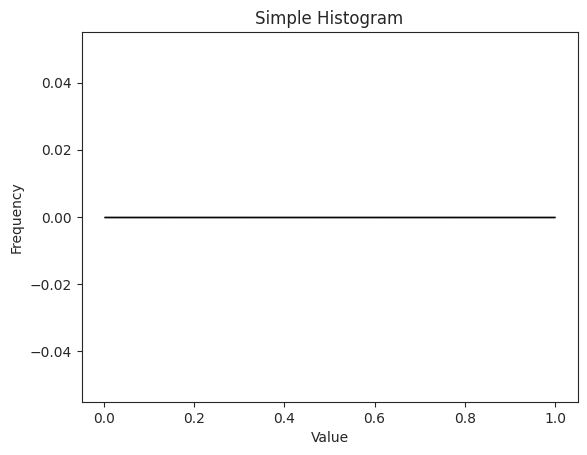

In [55]:
# Sample data
data = [1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10]

# Plotting the histogram
plt.hist([i for k,i in enumerate(rowGeneExpression.values())], bins=50, edgecolor="k", alpha=0.7)
plt.hist([i for k,i in enumerate(rowGeneExpression.values()) if not dependent_variables[k]], bins=50, edgecolor="k", alpha=0.7)
plt.hist([i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]], bins=50, edgecolor="k", alpha=0.7)

# Adding titles and labels
plt.title("Simple Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")



# Displaying the plot
plt.show()

def plot(l):
    plt.hist([i for k,i in enumerate(l)], bins=50, edgecolor="k", alpha=0.7)

# Adding titles and labels
    plt.title("Simple Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    # Displaying the plot
    plt.show()

In [7]:
import os
import pathlib

# print(pathlib.Path('yourPath.example').suffix) # '.example'
# print(pathlib.Path("hello/foo.bar.tar.gz").suffixes) # ['.bar', '.tar', '.gz']
# print(pathlib.Path('/foo/bar.txt').stem) # 'bar'

folders = '/home/awahab/llm-testing/data_sets/'
#fp = 'FrangiehIzar2021_RNA.h5ad' - control means probably works
fp = 'TianKampmann2021_CRISPRi.h5ad'
fp2 = 'TianKampmann2021_CRISPRa.h5ad'

#adata = sc.read_h5ad(folders + fp)

files = [fp for fp in os.listdir(folders) if pathlib.Path(fp).suffix == '.h5ad']


#print(files)
def runNNWithData(file_name):
    file_name = folders + file_name
    adata = sc.read_h5ad(file_name)
    print(file_name)
    #print(adata.obs.columns)
    t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df = h5adToData(adata)
    runNN(t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df)
    
#runNNWithData(fp2, files)
#for f in files[1:]: runNNWithData(f)

#runNNWithData(one)

# file_name = folders + 'DatlingerBock2017.h5ad'
# adata = sc.read_h5ad(file_name)
#print(adata.obs.columns)
#t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df = h5adToData(adata)
#runNN(t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df)

In [ ]:
all_url = [
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406675_10X001.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406677_10X005.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406681_10X010.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AissaBenevolenskaya2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/ChangYe2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DatlingerBock2017.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DatlingerBock2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DixitRegev2016.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/FrangiehIzar2021_protein.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/FrangiehIzar2021_RNA.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/GasperiniShendure2019_atscale.h5ad?download=1",
    
    "https://zenodo.org/record/7416068/files/GasperiniShendure2019_highMOI.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/GasperiniShendure2019_lowMOI.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/GehringPachter2019.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/McFarlandTsherniak2020.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/NormanWeissman2019_filtered.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_protein.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_RNA.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_protein.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_RNA.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_essential.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_gwps.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_rpe1.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchiebingerLander2019_GSE106340.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchiebingerLander2019_GSE115943.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ShifrutMarson2018.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex2.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex3.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex4.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2019_day7neuron.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2019_iPSC.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRa.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRi.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/WeinrebKlein2020.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/XieHon2017.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ZhaoSims2021.h5ad?download=1"
]

import requests
 
# def download_url(url):
#   print("downloading: ",url)
#   # assumes that the last segment after the / represents the file name
#   # if url is abc/xyz/file.txt, the file name will be file.txt
#   file_name_start_pos = url.rfind("/") + 1
#   file_name = url[file_name_start_pos:]
 
#   r = requests.get(url, stream=True)
#   if r.status_code == requests.codes.ok:
#     with open(file_name, 'wb') as f:
#       for data in r:
#         f.write(data)

#for link in url: download_url(link)
    #https://zenodo.org/record/7058382
    
#find data set with some perturbed and some not
#train on a half with some of both 
#apply to other half and see if predictions are true


import requests
from multiprocessing.pool import ThreadPool

# def download_url(url):
#   print("downloading: ",url)
#   # assumes that the last segment after the / represents the file name
#   # if url is abc/xyz/file.txt, the file name will be file.txt
#   file_name_start_pos = url.rfind("/") + 1
#   file_name = url[file_name_start_pos:]

#   r = requests.get(url, stream=True)
#   if r.status_code == requests.codes.ok:
#     with open(file_name, 'wb') as f:
#       for data in r:
#         f.write(data)
#   return url

# results = ThreadPool(5).imap_unordered(download_url, url)
# for r in results:
#     print(r)

import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from tqdm import tqdm
from PIL import Image
from io import BytesIO

root_url = "https://zenodo.org/record/7058382"

def download_file(file_path):
    if os.path.isfile(folders+file_path): return print(f"${file_path} already exists")
    url = f"{file_path}"
    print(url)
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {file_path}: {e}")
        return None

    if response.status_code == 200:
        # Extract the directory and filename from the file path
        directory, filename = os.path.split(file_path)
        # Create the directory if it doesn't exist
        os.makedirs(directory, exist_ok=True)
        # Save the file as JPEG
        try:
            image = Image.open(BytesIO(response.content))
            image.save(file_path, "JPEG")
            return file_path
        except IOError:
            return None
    else:
        return None

# Send an HTTP GET request to the URL
response = requests.get(root_url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the response
    #soup = BeautifulSoup(response.content, 'html.parser')

    # Find all <a> tags that represent links
    #links = soup.find_all('a')

    # Extract the href attribute of each link
    file_urls = all_url

    # Create a ThreadPoolExecutor with maximum 256 worker threads
    executor = ThreadPoolExecutor(max_workers=20)

    # Use a list to store the download tasks
    tasks = []

    # Use tqdm to create a progress bar
    with tqdm(total=len(file_urls)) as progress_bar:
        error_count = 0
        # Submit the download tasks
        for file_name in file_urls:
            task = executor.submit(download_file, file_name)
            tasks.append(task)

        # Process the completed tasks
        for completed_task in as_completed(tasks):
            result = completed_task.result()
            if result is None:
                error_count += 1
            progress_bar.update(1)

    print(f"All downloads completed, errors: {error_count}")

  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_essential.h5ad?download=1
https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_protein.h5ad?download=1
https://zenodo.org/record/7416068/files/NormanWeissman2019_filtered.h5ad?download=1
https://zenodo.org/record/7416068/files/GehringPachter2019.h5ad?download=1
https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_RNA.h5ad?download=1
https://zenodo.org/record/7416068/files/GasperiniShendure2019_lowMOI.h5ad?download=1
https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_RNA.h5ad?download=1
https://zenodo.org/record/7416068/files/McFarlandTsherniak2020.h5ad?download=1
https://zenodo.org/record/7416068/files/GasperiniShendure2019_highMOI.h5ad?download=1
https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_gwps.h5ad?download=1
https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_protein.h5ad?download=1
https://zenodo.org/record/7416068/files/Repl

  4%|███                                                                                 | 1/27 [00:03<01:25,  3.29s/it]

https://zenodo.org/record/7416068/files/TianKampmann2019_day7neuron.h5ad?download=1
https://zenodo.org/record/7416068/files/TianKampmann2019_iPSC.h5ad?download=1


 11%|█████████▎                                                                          | 3/27 [00:27<03:56,  9.87s/it]

https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRa.h5ad?download=1


 15%|████████████▍                                                                       | 4/27 [00:27<02:30,  6.56s/it]

https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRi.h5ad?download=1


 19%|███████████████▌                                                                    | 5/27 [00:31<02:02,  5.56s/it]

https://zenodo.org/record/7416068/files/WeinrebKlein2020.h5ad?download=1


 22%|██████████████████▋                                                                 | 6/27 [00:34<01:38,  4.71s/it]

https://zenodo.org/record/7416068/files/XieHon2017.h5ad?download=1


 26%|█████████████████████▊                                                              | 7/27 [00:35<01:09,  3.45s/it]

https://zenodo.org/record/7416068/files/ZhaoSims2021.h5ad?download=1


 33%|████████████████████████████                                                        | 9/27 [01:10<02:54,  9.68s/it]

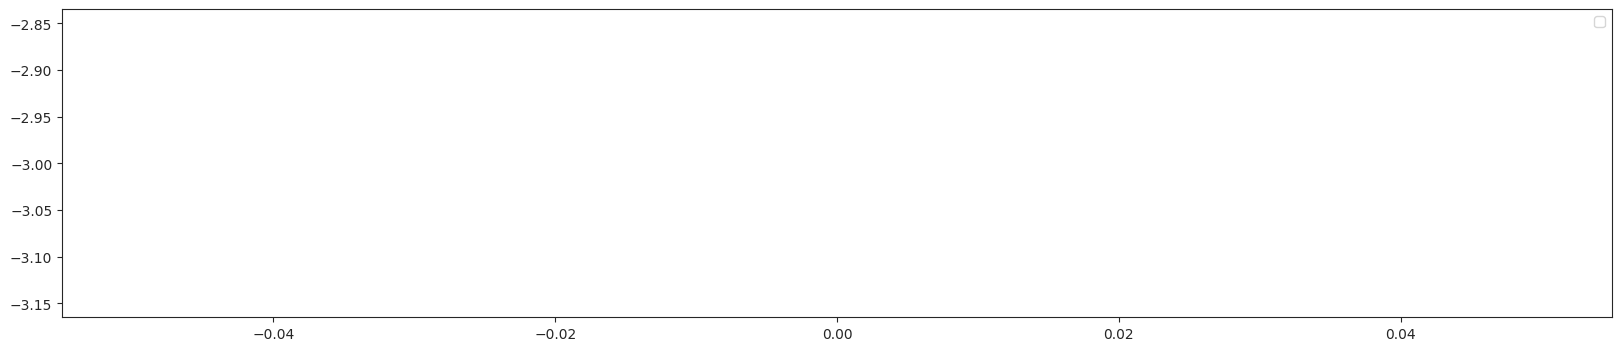

In [56]:
#https://zenodo.org/record/7058382
#http://projects.sanderlab.org/scperturb/datavzrd/scPerturb_vzrd_v1/dataset_info/index_1.html
#https://nbisweden.github.io/workshop-scRNAseq/
#https://github.com/fastai/course22p2/blob/master/nbs/15_DDPM.ipynb
#plt.hist(, bins=50, edgecolor="k", alpha=0.7)

plt.figure(figsize=(20, 4))
legends = []

blue = [i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]]
oj =[i for k,i in enumerate(rowGeneExpression.values()) if not dependent_variables[k]]
blue.sort()
oj.sort()
plt.plot((blue)) #blue true peturbation 
plt.plot(oj) #orange false ctrl

#legends.append('param %d' % i)
plt.plot([0, len([i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
#https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02021-3

# Medicine Finding anomalies in radiology images, including CT, MRI, and X-ray images; counting features in pathology slides; measuring features in ultrasounds; diagnosing diabetic retinopathy
#Biology Folding proteins; classifying proteins; many genomics tasks, such as tumor-normal sequencing and classifying clinically actionable genetic mutations; cell classification; analyzing protein/protein interactions
#Other applications Financial and logistical forecasting, text to speech, and much more…
# humor analysis - larry david vs seinfeld ? 

In [115]:
#https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework
#handle "values outside of domain" by "SVM"
#random forest classifier
#logisitc regression - hard to get right
#correct transformations, outlier handling, correct interactions
#os.listdir('./data_sets')
#wget -m http://www.example.com 2>&1 | grep '^--' | awk '{ print $3 }' | grep -v '\.\(css\|js\|png\|gif\|jpg\|JPG\)$' > urls.txt
# dls = TabularPandas(
#     df, splits=splits,
#     procs = [Categorify, FillMissing, Normalize],
#     cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
#     cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
#     y_names="Survived", y_block = CategoryBlock(),
# ).dataloaders(path=".")

# import matplotlib.pyplot as plt
# import numpy as np

# # a 2D array with linearly increasing values on the diagonal
# a = np.diag(range(15))

# plt.matshow(adata.X[:100,:100])

# plt.show()
torch.autograd.set_detect_anomaly(True)
def softmax_activation(z):
    exponentials = torch.exp(z)
    exponentials_row_sums = torch.sum(exponentials, axis=1).unsqueeze(1)  # 1
    return exponentials / exponentials_row_sums
#sc.pl.DotPlot(adata, hv_genes,  groupby='perturbation').show()
#sc.pl.MatrixPlot(adata, hv_genes, groupby='perturbation').show()
len(hv_genes)

200

In [299]:
import torch
import math


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)
print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')
learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

Result: y = -0.5361047983169556 + 0.5151747465133667 x + 0.4837605655193329 x^2 + 0.4703100025653839 x^3
99 357.0294189453125
199 249.68206787109375
299 175.5972137451172
399 124.41352844238281
499 89.01506042480469
599 64.50860595703125
699 47.52596664428711
799 35.74573516845703
899 27.566566467285156
999 21.882465362548828
1099 17.928773880004883
1199 15.176361083984375
1299 13.258647918701172
1399 11.92142105102539
1499 10.988264083862305
1599 10.336601257324219
1699 9.881195068359375
1799 9.562718391418457
1899 9.33985424041748
1999 9.183808326721191
Result: y = -0.01894792728126049 + 0.8501335978507996 x + 0.003268833737820387 x^2 + -0.09239056706428528 x^3


In [ ]:
def add_features(df):
#     df['LogFare'] = np.log1p(df['Fare'])
#     df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
#     df['Family'] = df.SibSp+df.Parch
#     df['Alone'] = df.Family==0
#     df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
#     df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
#     df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))
    #df.drop(columns=['n_perts'])
    return 10
loss_function = torch.nn.CrossEntropyLoss()

model = torch.nn.Sequential(
    torch.nn.Linear(5, 5)
)
lambda_param = 0.01

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=.1, 
    weight_decay=lambda_param
)

n_iterations = 250
for i in range(1, n_iterations + 1):
    Z = model(t_indep)  # 1
    loss = loss_function(Z, t_dep)  # 2
    optimizer.zero_grad()  # 3
    loss.backward()  # 4
    optimizer.step()  # 5
    
    if i == 1 or i % 25 == 0:
        print("Loss at iteration {}: {}".format(i, loss))

test_predictions = model(trn_indep)
# test_accuracy = flaoat(sum(test_predictions == y_test)) / y_test.shape[0]
# print("\nFinal Test Accuracy: {}".format(test_accuracy))

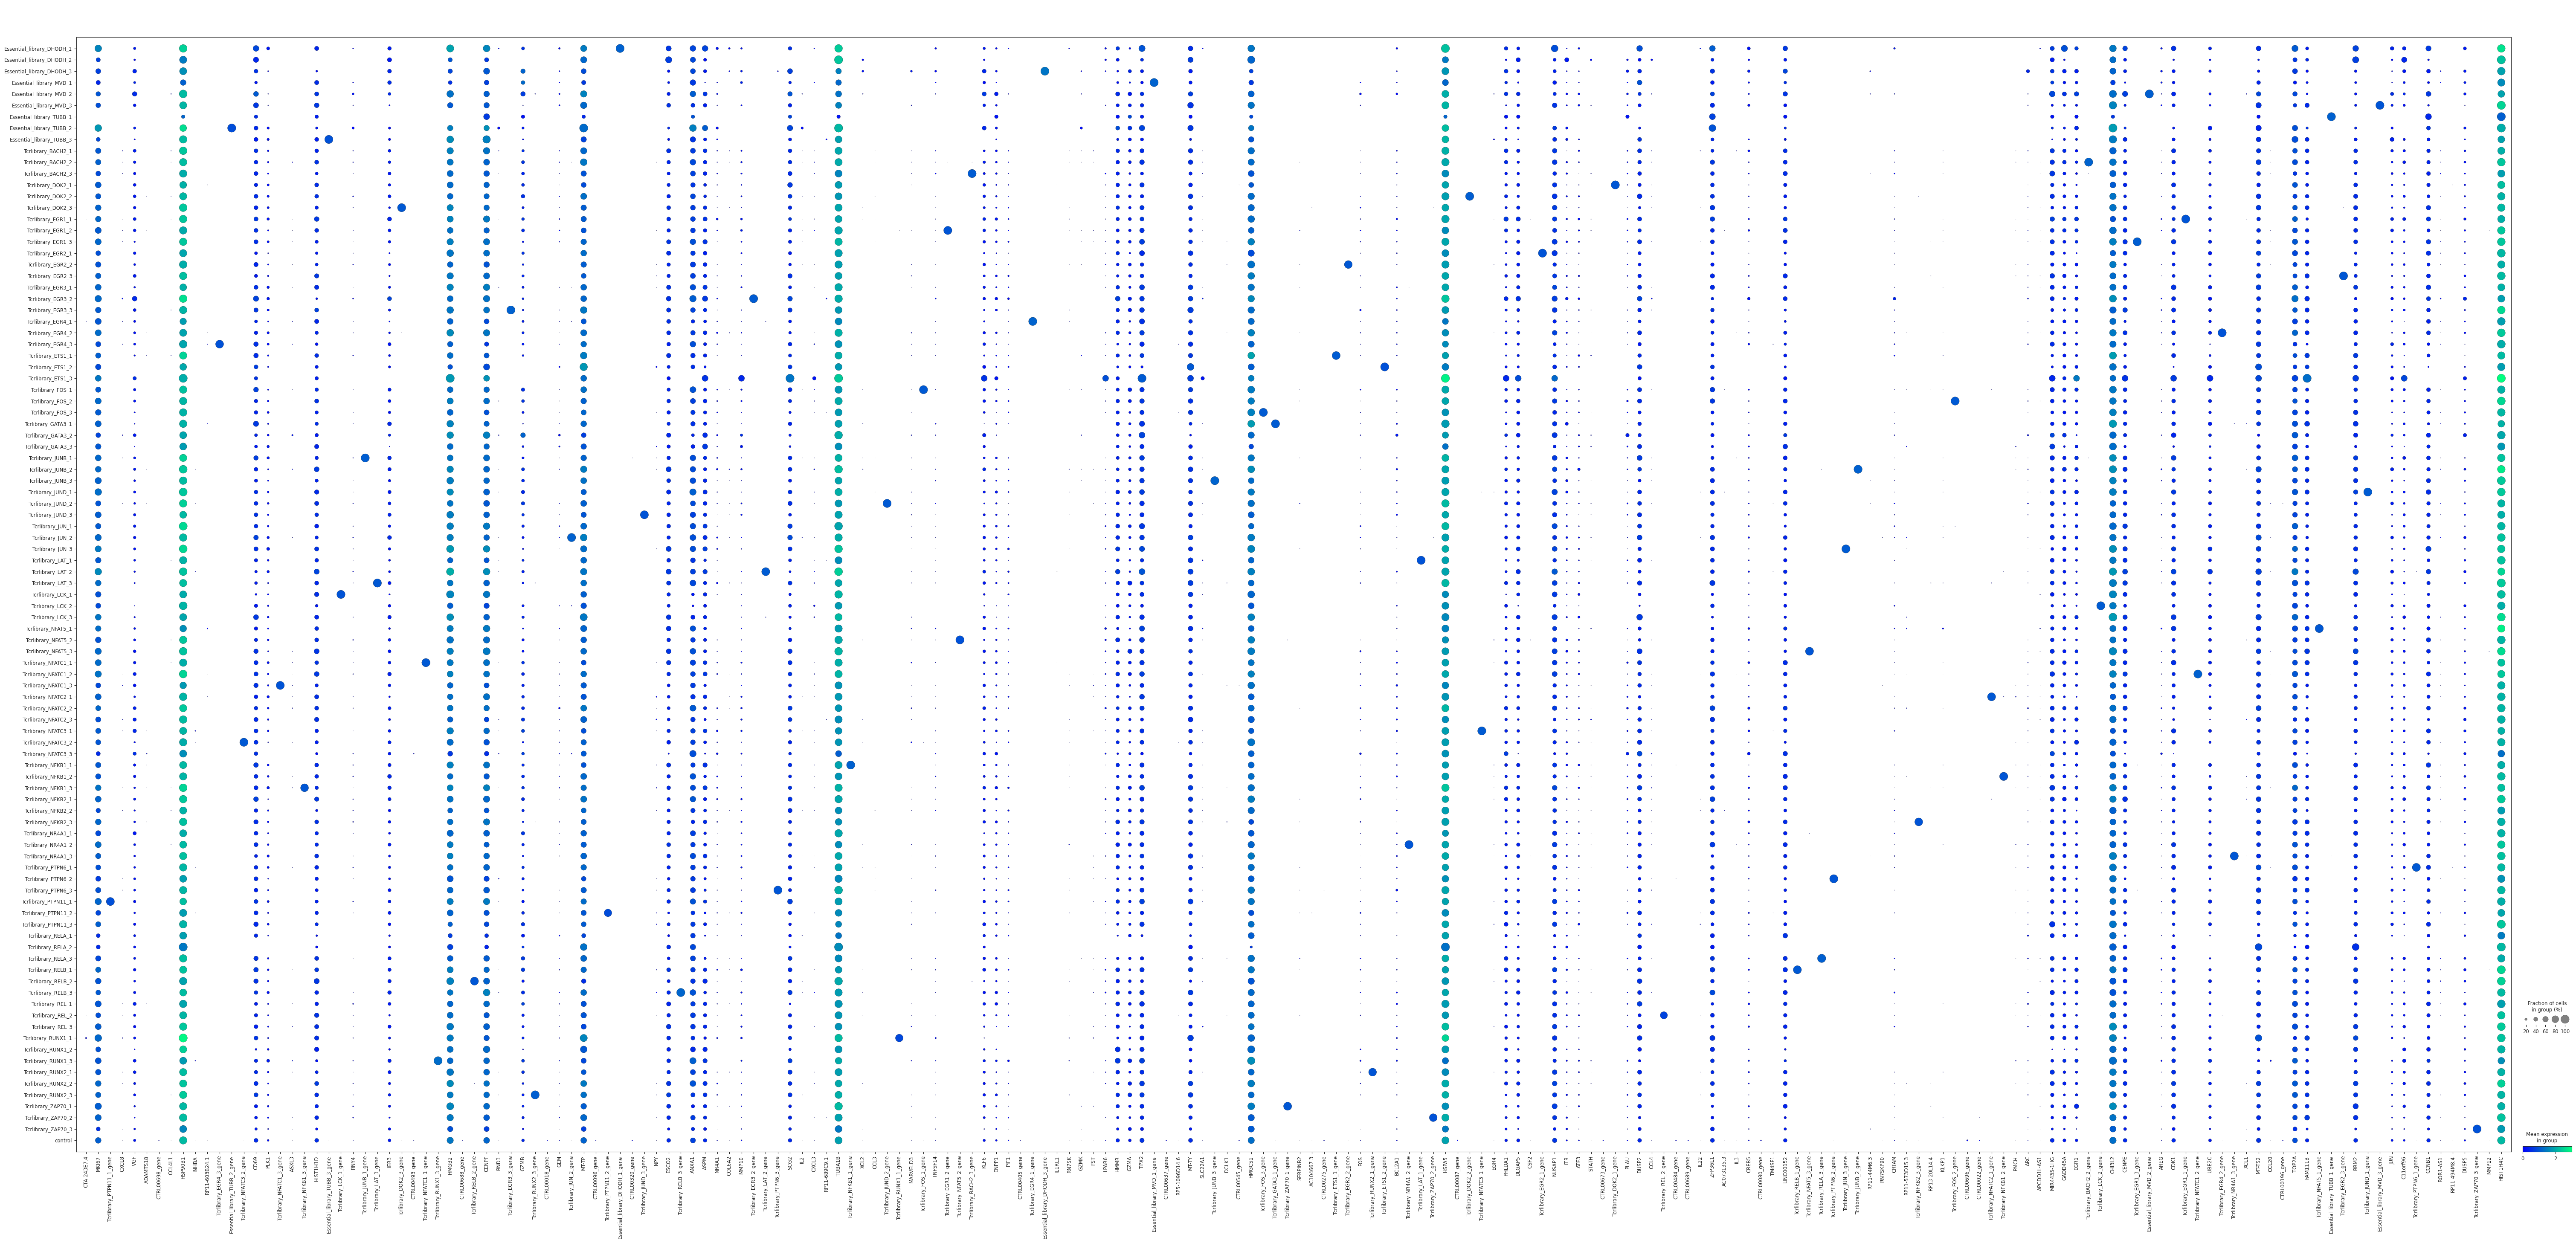

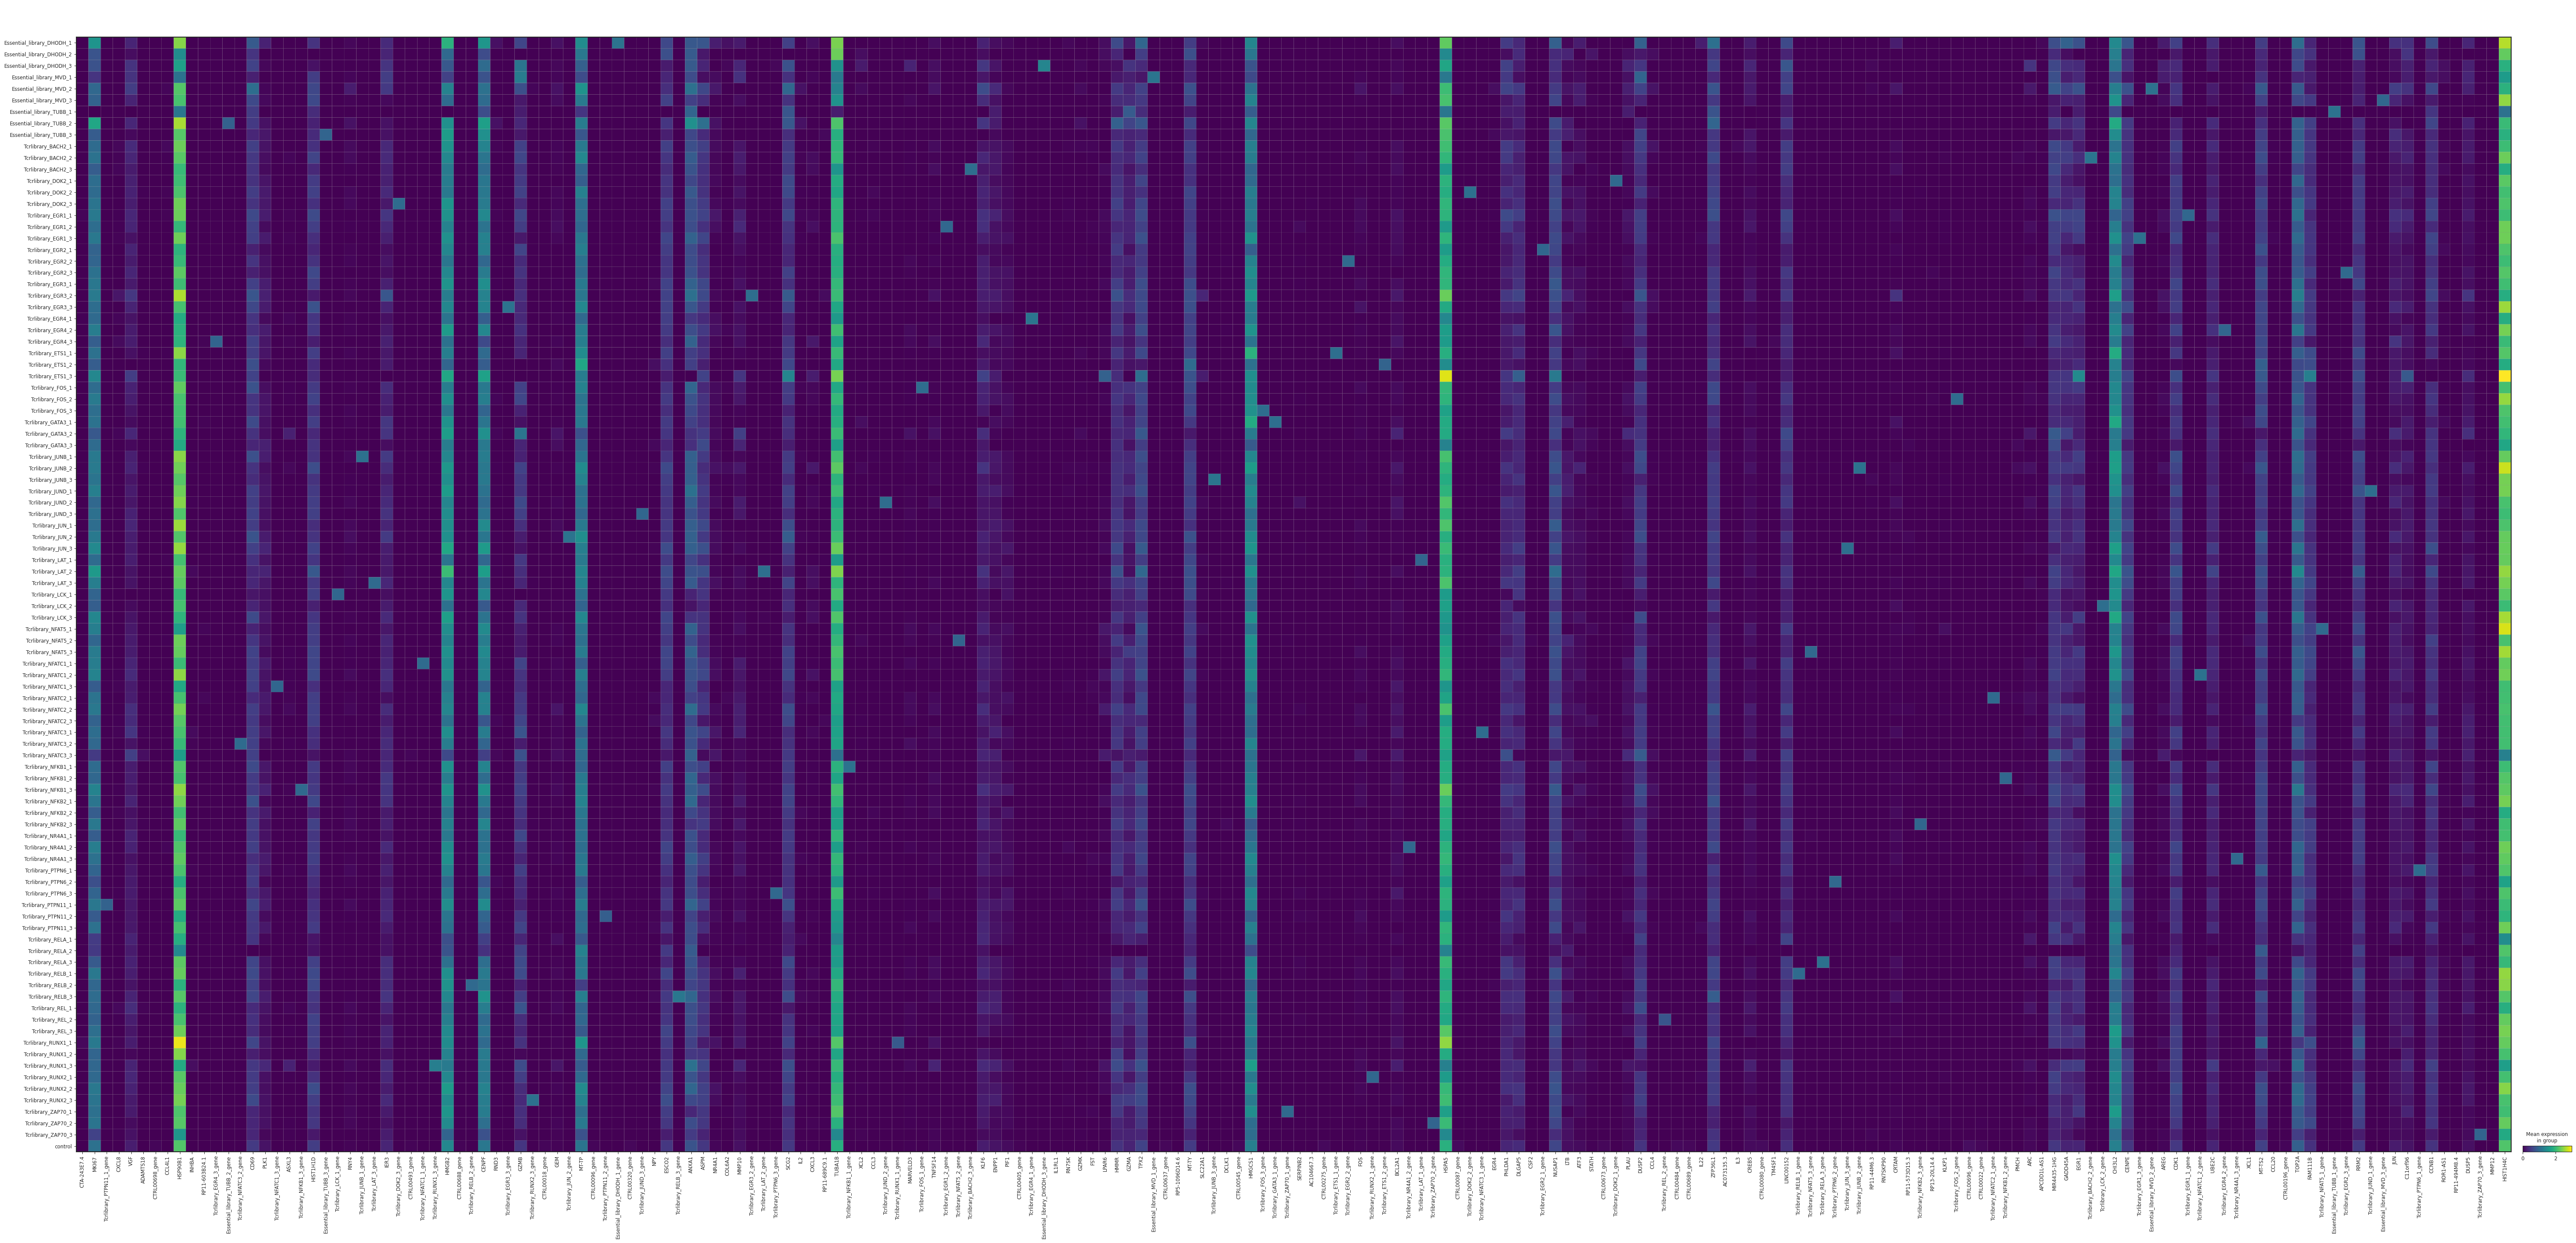

In [120]:
hg = list(hv_genes)
sc.pl.DotPlot(adata, hg,  groupby='perturbation').show()
sc.pl.MatrixPlot(adata, hg, groupby='perturbation').show()

In [ ]:
def intent_inference():
    return 'walking' if True else 'sit'

#https://www.10xgenomics.com/resources/datasets/5-k-a-549-lung-carcinoma-cells-no-treatment-transduced-with-a-crispr-pool-3-1-standard-6-0-0